# Задача 6. Компьютерное зрение: задача сегментации

* **Дедлайн**: 11.04.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

Обучаем Сегментацию:
- https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.


- [ ] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [ ] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [ ] Попробовать улучшить качество изменяя архитектуру.
- [ ] * (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?
- [ ] * (**+3 балла**) Сделать unet с pretrained энкодером (можно взять vgg или resnet18/34), сравнить с предыдущими пунктами.

In [ ]:
!pip install torchmetrics

In [198]:
from copy import copy
import pandas as pd
import random
import seaborn as sns
import torch
import torch.utils.data
from torchmetrics import JaccardIndex

import os
from matplotlib import pyplot as plt
from pathlib import Path
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset, Dataset
from torchvision import io, transforms
from torchvision.transforms import functional
from torchvision.io import read_image
from tqdm.auto import tqdm, trange
from torch import optim
from torch.utils.data import random_split
import albumentations as A
import cv2
from sklearn.model_selection import KFold
import numpy as np
from albumentations.pytorch import ToTensorV2

In [3]:
device = torch.device("cuda")

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

### Датасет

In [15]:
# !gdown 11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe
# !unzip dataset.zip
!ls dataset/

images	masks


In [253]:
class ImageDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

        _, mask = cv2.threshold(mask, 100, 1, cv2.THRESH_BINARY)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = torch.Tensor(mask.astype(int))[None, ...]
        image = torch.Tensor(image.copy()).permute(2, 0, 1) / 255.
        return image, mask

500


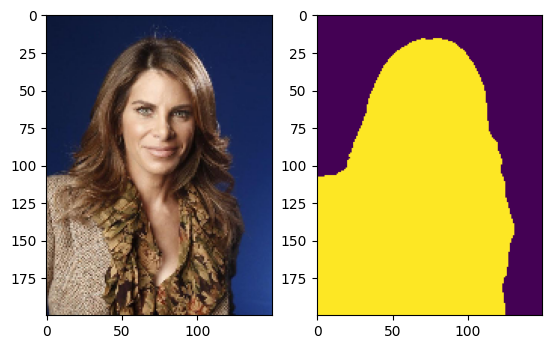

In [255]:
# image_paths = sorted(Path("dataset/images").iterdir())
# mask_paths = sorted(Path("dataset/masks").iterdir())
image_paths = sorted(Path("dataset/images").iterdir())[:500]
mask_paths = sorted(Path("dataset/masks").iterdir())[:500]
dataset = ImageDataset(image_paths, mask_paths, transform=A.Compose([
    A.Resize(height=200, width=150),
  ]))

def show(images):
    _, axes = plt.subplots(ncols=len(images))
    for ax, image in zip(axes, images):
        ax.imshow(functional.to_pil_image(image))

print(len(dataset))
show(dataset[0])

### train/test split

In [262]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

bs = 8
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True, num_workers=2)

train_loader_small = DataLoader(Subset(train_dataset, range(bs)), batch_size=bs)
test_loader_small = DataLoader(Subset(test_dataset, range(bs)), batch_size=bs)

### UNet

In [227]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, default=True):
        super(CNNBlock, self).__init__()

        seq = (
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ) if default else (
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
        )

        self.seq_block = nn.Sequential(*seq)

    def forward(self, x):
        return self.seq_block(x)


class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding, default=True):
        super(CNNBlocks, self).__init__()

        self.layers = nn.ModuleList()
        for _ in range(n_conv):
            self.layers.append(CNNBlock(in_channels, out_channels, padding=padding, default=default))
            in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4, default=True):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [
                CNNBlocks(
                    n_conv=2,
                    in_channels=in_channels,
                    out_channels=out_channels,
                    padding=padding,
                    default=default,
                ),
                nn.MaxPool2d(2, 2),
            ]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(
            CNNBlocks(
                n_conv=2,
                in_channels=in_channels,
                out_channels=out_channels,
                padding=padding,
                    default=default,
            )
        )

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4, default=True):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                CNNBlocks(
                    n_conv=2,
                    in_channels=in_channels,
                    out_channels=out_channels,
                    padding=padding,
                    default=default,
                ),
            ]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(
            nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0)
        )

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                dim_4 = connections_current.size(3) - x.size(3)
                dim_3 = connections_current.size(2) - x.size(2)
                if dim_4 != 0 or dim_3 != 0:
                    x = nn.functional.pad(x, [0, dim_4, 0, dim_3])
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x


class UNET(nn.Module):
    def __init__(
        self, in_channels=3, first_out_channels=16, exit_channels=1, n_down=4, padding=1, default=True
    ):
        super(UNET, self).__init__()
        self.encoder = Encoder(
            in_channels, first_out_channels, padding=padding, n_down=n_down, default=default
        )
        self.decoder = Decoder(
            first_out_channels * (2**n_down),
            first_out_channels * (2 ** (n_down - 1)),
            exit_channels,
            padding=padding,
            n_up=n_down,
            default=default,
        )

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)


##### Функции для тренировки

In [10]:
def train_epoch(model, optimizer, loader):
    model.train()

    loss_sum = 0
    jaccard_sum = 0

    for X, y in loader:
        X, y = X.cuda(), y.cuda()

        pred = model(X)
        loss = criterion(pred, y)
        jaccards = jaccard(pred.cpu(), y.cpu() > jaccard.threshold)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        jaccard_sum += jaccards.item()

    return loss_sum / len(loader), jaccard_sum / len(loader)

@torch.no_grad()
def test(model, loader):
    model.eval()

    loss_sum = 0
    jaccard_sum = 0

    for X, y in loader:
        X, y = X.cuda(), y.cuda()

        pred = model(X)

        loss_sum += criterion(pred, y).item()
        jaccard_sum += jaccard(pred.cpu(), y.cpu() > jaccard.threshold).item()

    return loss_sum / len(loader), jaccard_sum / len(loader)

def train(model, optimizer, train_loader, test_loader, num_epochs, save_dir=None):
    statistics = []

    for epoch in trange(num_epochs, desc="Epoch"):
        train_loss, train_metric = train_epoch(model, optimizer, train_loader)
        test_loss, test_metric = test(model, test_loader)

        statistics.extend([
            (epoch, "Loss", "Train", train_loss),
            (epoch, "Jaccard", "Train", train_metric),
            (epoch, "Loss", "Test", test_loss),
            (epoch, "Jaccard", "Test", test_metric),
        ])

        if save_dir is not None:
            torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}.pt"))

    return pd.DataFrame(statistics, columns=["Epoch", "Statistic", "Dataset", "Value"])

### Переобучение
Переобучим модель на одном батче

In [233]:
net_overfit = UNET().cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net_overfit.parameters(), lr=5e-4)
jaccard = JaccardIndex(task="binary")

In [234]:
train(net_overfit, optimizer, train_loader_small, test_loader_small, num_epochs=100).to_csv("overfit.csv")

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [210]:
def plot_stats(stats):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))
    fig.tight_layout()

    for idx, (ax, stat) in enumerate(zip(axes, ["Loss", "Jaccard"])):
        data = stats[stats["Statistic"] == stat]
        sns.lineplot(data=data, x="Epoch", y="Value", hue="Dataset", ax=ax)
        ax.set_title(stat)
        ax.grid(True)
        for _, row in data[data["Statistic"] == stat].iterrows():
            ax.text(row["Epoch"], row["Value"], "")

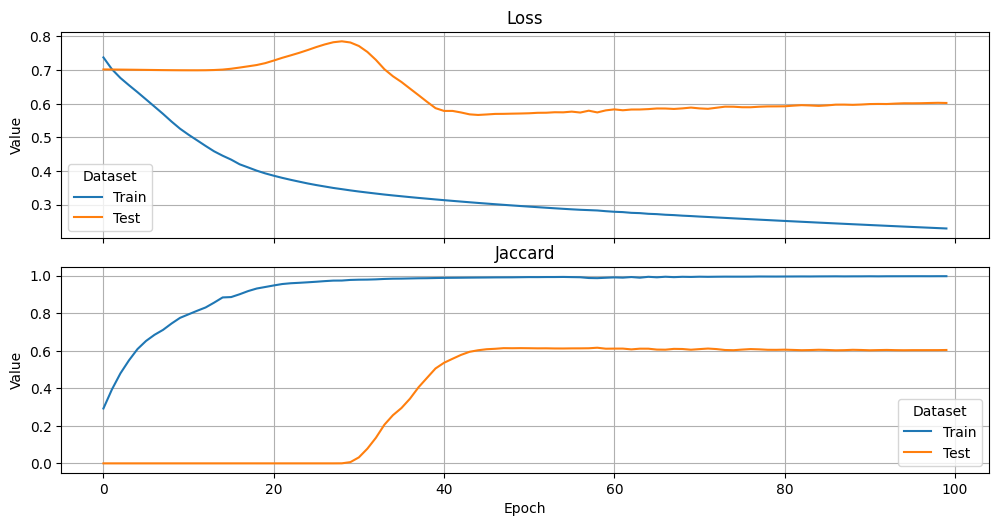

In [235]:
plot_stats(pd.read_csv("overfit.csv"))

In [16]:
@torch.no_grad()
def show_worst_case(model, dataset, n=3):
    test_metrics = []
    for i, (X, y) in enumerate(dataset):
        pred = model(X.cuda().unsqueeze(0))[0].cpu()
        test_metrics.append((jaccard(pred.cpu(), y.cpu() > jaccard.threshold).item(), i))

        idx = [i for _, i in sorted(test_metrics)[:n]]

    with torch.no_grad():
        for i in idx:
            X, y = dataset[i]
            pred = model(X.cuda().unsqueeze(0))[0].cpu()
            show([X, nn.functional.sigmoid(pred), y])

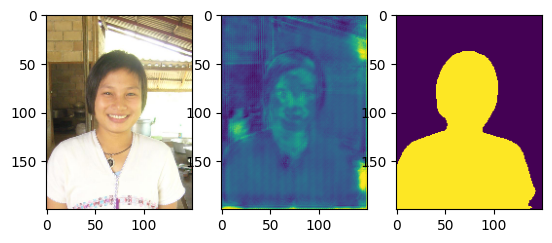

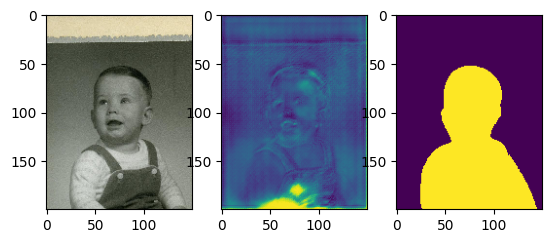

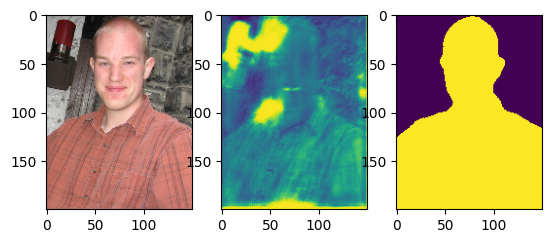

In [17]:
show_worst_case(net_overfit, test_dataset)

### Полное обучение

In [278]:
net = UNET().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-4)
jaccard = JaccardIndex(task="binary")

In [270]:
train(net, optimizer, train_loader, test_loader, num_epochs=40, save_dir="./").to_csv("statistics.csv")

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

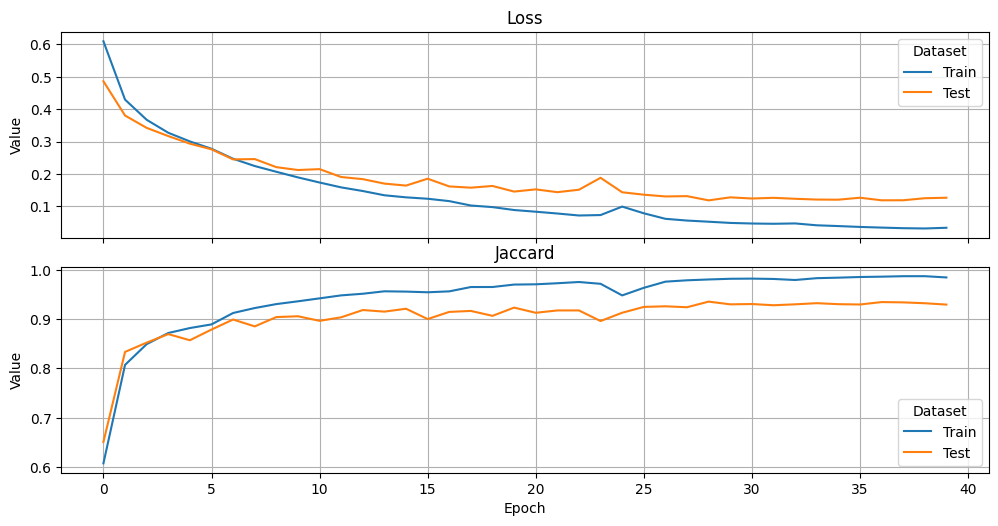

In [271]:
plot_stats(pd.read_csv("statistics.csv"))

Test loss перестаёт заметно снижаться после 30 эпохи, поэтому в дальнейшем будем использовать это число.

In [199]:
EPOCHS = 30

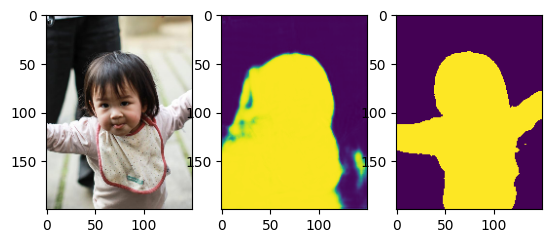

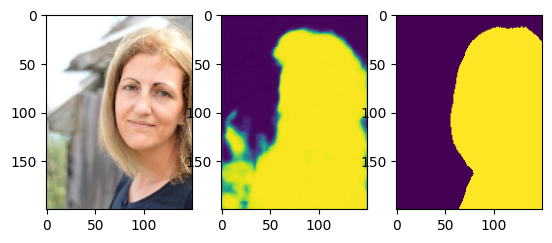

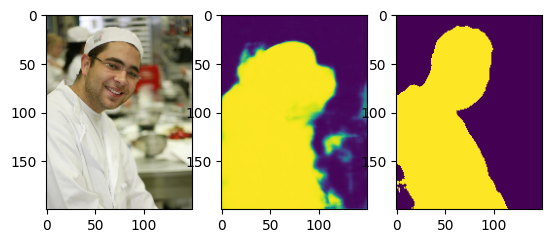

In [78]:
show_worst_case(net, test_dataset)

### Аугментация

In [93]:
transform = A.Compose([
    A.Resize(200, 200),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.4),
    A.RandomBrightnessContrast(p=0.4),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.3)
])

dataset_aug = ImageDataset(image_paths, mask_paths, transform=transform)

train_dataset_aug, test_dataset_aug = random_split(dataset_aug, [train_size, test_size])

train_loader_aug = DataLoader(train_dataset_aug, batch_size=bs, shuffle=True, num_workers=2)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=bs, shuffle=True, num_workers=2)

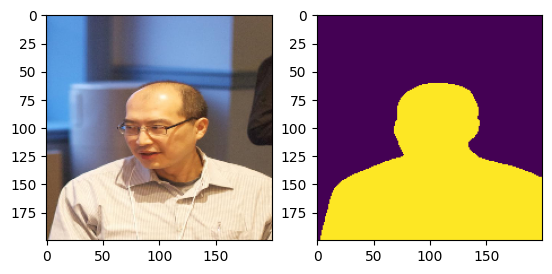

In [94]:
show(test_dataset_aug[0])

In [95]:
net_aug = UNET().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net_aug.parameters(), lr=5e-4)
jaccard = JaccardIndex(task="binary")

In [96]:
train(net_aug, optimizer, train_loader_aug, test_loader_aug, num_epochs=EPOCHS, save_dir="./").to_csv("statistics_aug.csv")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

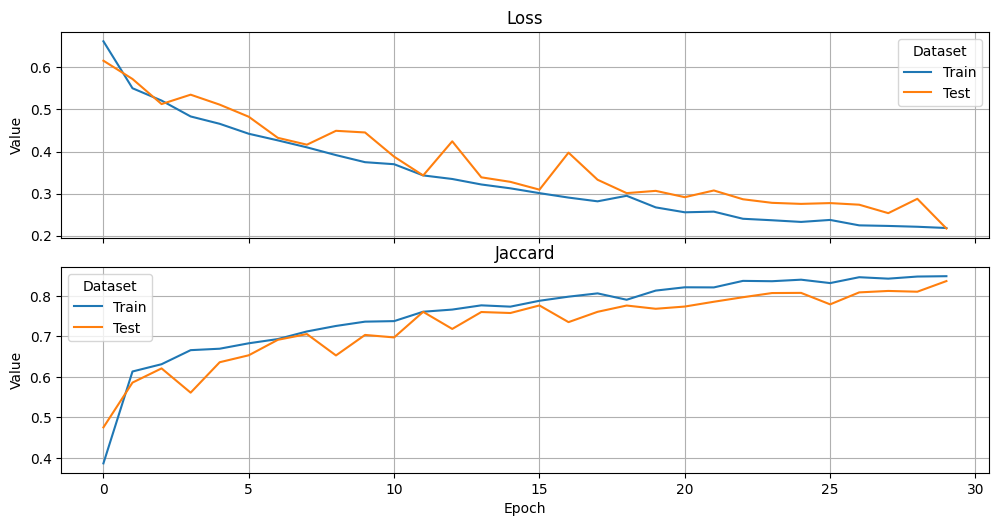

In [213]:
plot_stats(pd.read_csv("statistics_aug.csv"))

Точность несколько уменьшилась, однако уменьшилось и расхождение между train и test датасетами.

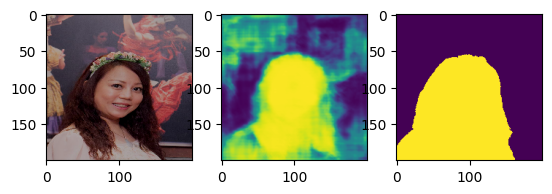

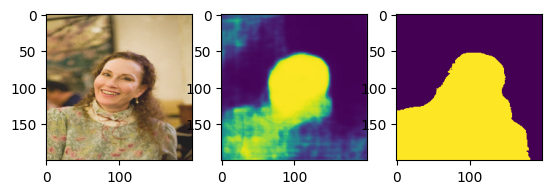

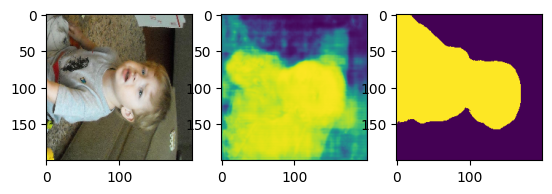

In [98]:
show_worst_case(net_aug, test_dataset_aug)

### Аритектура
\+ Dropout

\+ несколько слоев

In [279]:
net_2 = UNET(default=False).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net_2.parameters(), lr=5e-4)
jaccard = JaccardIndex(task="binary")

In [280]:
train(net_2, optimizer, train_loader, test_loader, num_epochs=EPOCHS).to_csv("net_2.csv")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

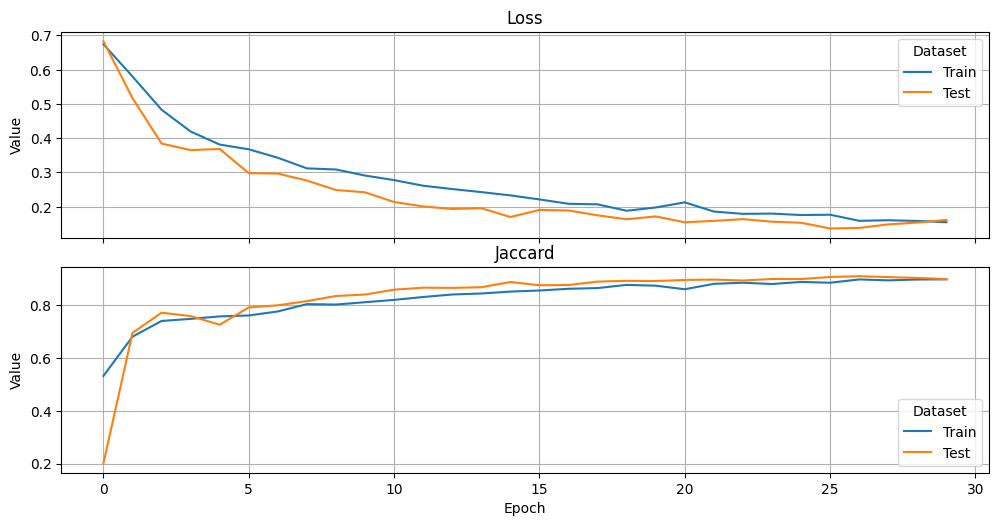

In [281]:
plot_stats(pd.read_csv("net_2.csv"))

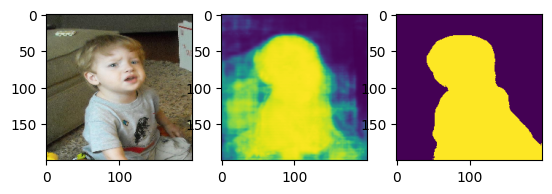

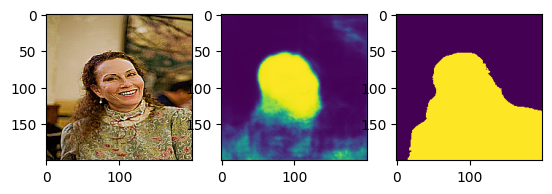

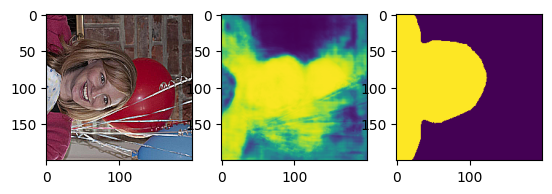

In [247]:
show_worst_case(net_aug, test_dataset_aug)

### KFold

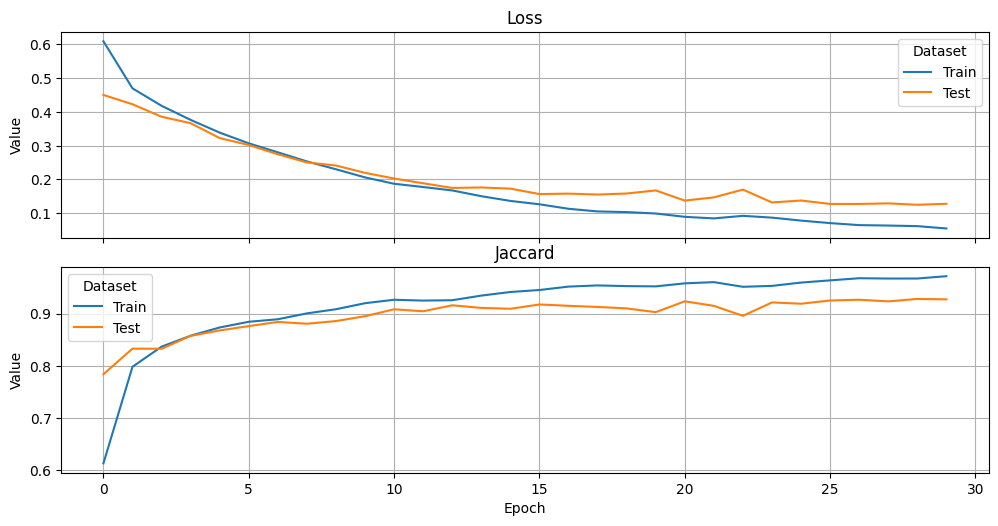

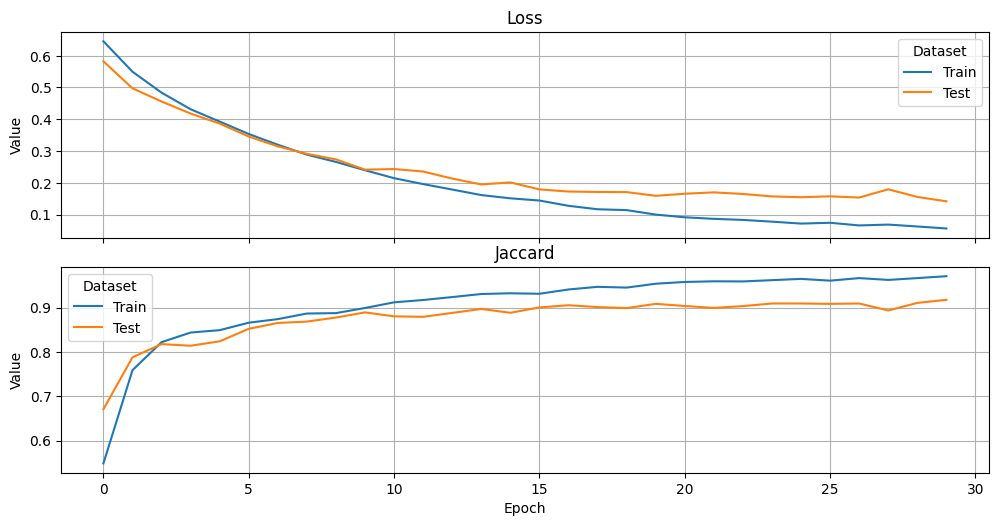

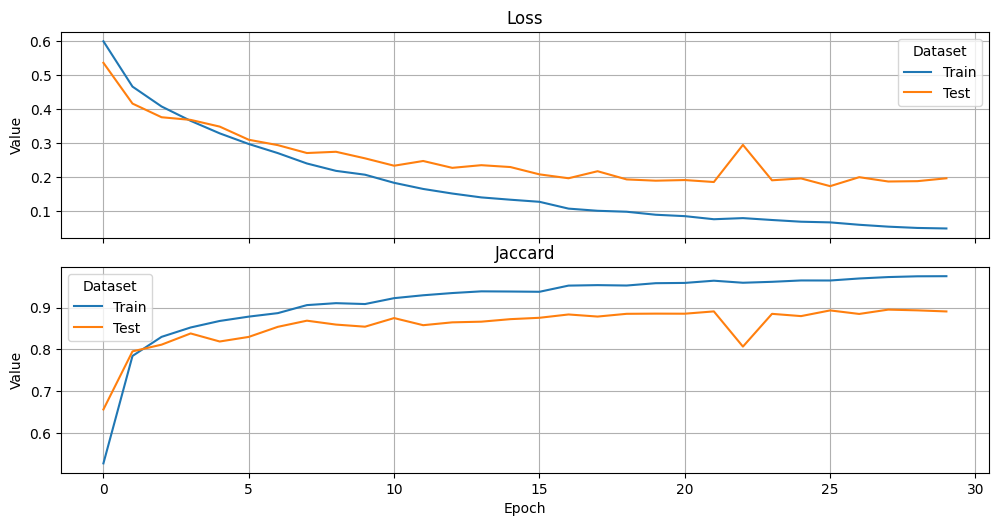

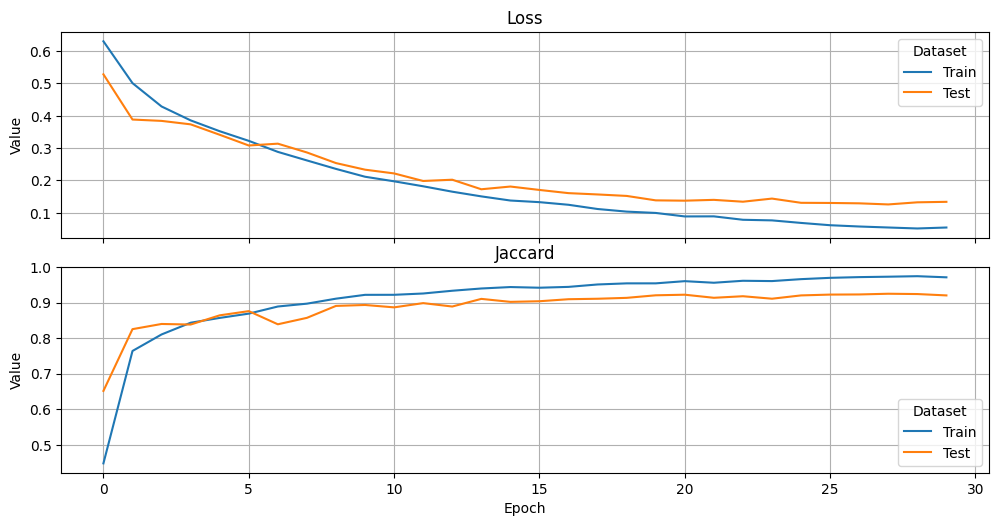

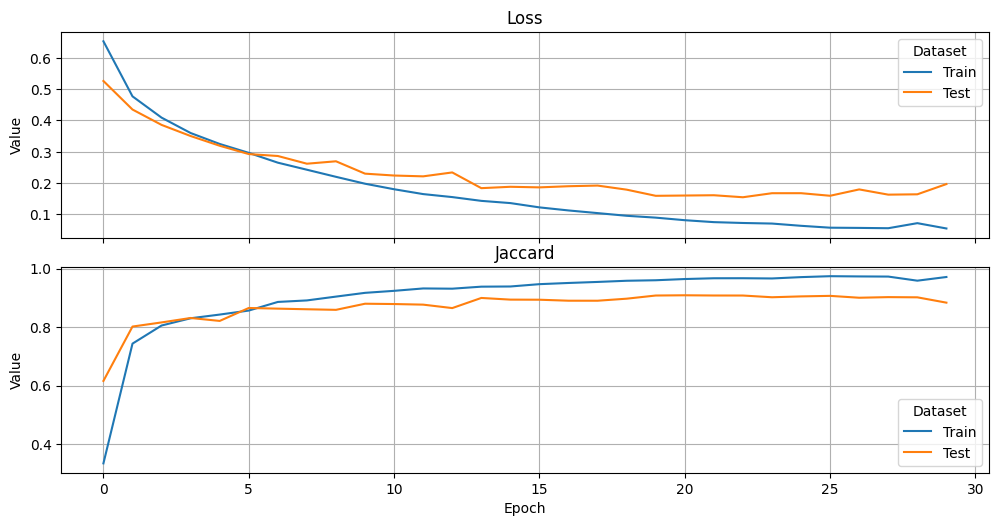

In [215]:
kfold = KFold(n_splits=5, shuffle=True)

for i, (train_index, test_index) in enumerate(kfold.split(dataset)):
    train_l = DataLoader(Subset(dataset, train_index), batch_size=bs, shuffle=True, num_workers=2)
    test_l = DataLoader(Subset(dataset, test_index), batch_size=bs, shuffle=True, num_workers=2)

    net = UNET().cuda()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=5e-4)

    train(net, optimizer, train_l, test_l, EPOCHS).to_csv(f"fold_{i}.csv")

    plot_stats(pd.read_csv(f"fold_{i}.csv"))

Результаты модели на фолдах достаточно близки к результатам на всем датасете, так что наша изначальная модель не переобучилась

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()